# Plot Something

In [27]:
%matplotlib inline
import cosima_cookbook as cc
from dask.distributed import Client
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from cosima_cookbook import explore

In [28]:
db = 'anu-tub.db'
session=cc.database.create_session(db)
experiment='anu-tub-control'

In [29]:
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:46853 Dashboard: /proxy/34283/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


# Spinup Diagnostics


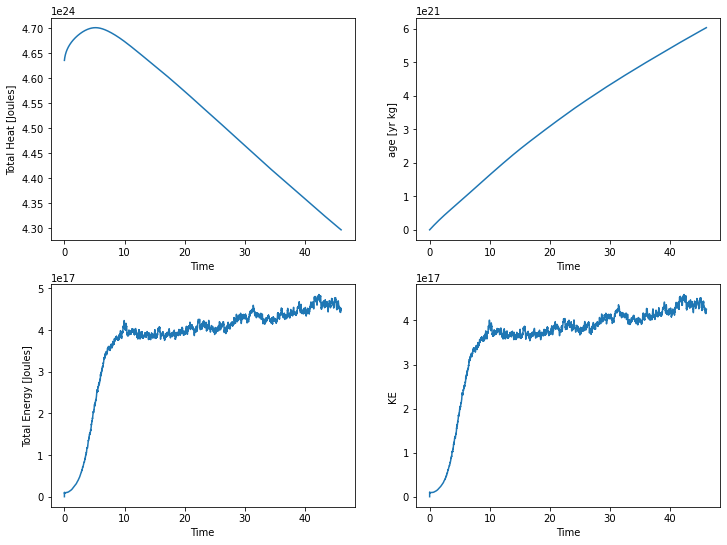

In [50]:
fig, ax = plt.subplots(2,2,figsize=(12,9))

variable = 'Heat'
darray = cc.querying.getvar(experiment, variable, session,ncfile='ocean.stats.nc',decode_times=False)
darray.coords['Time'] = darray.coords['Time']/365
darray.plot(ax=ax[0,0])
                                               
variable = 'En'
darray = cc.querying.getvar(experiment, variable, session,ncfile='ocean.stats.nc',decode_times=False)
darray.coords['Time'] = darray.coords['Time']/365
darray.plot(ax=ax[1,0])

variable = 'age'
darray = cc.querying.getvar(experiment, variable, session,ncfile='ocean.stats.nc',decode_times=False)
darray.coords['Time'] = darray.coords['Time']/365
darray.plot(ax=ax[0,1])
                                               
variable = 'KE'
darray = cc.querying.getvar(experiment, variable, session,ncfile='ocean.stats.nc',decode_times=False)
darray.coords['Time'] = darray.coords['Time']/365
darray.sum('Layer').plot(ax=ax[1,1])

# Extra Spinup Diagnostics

Text(0.5, 1.0, 'Tropical Temperature evolution')

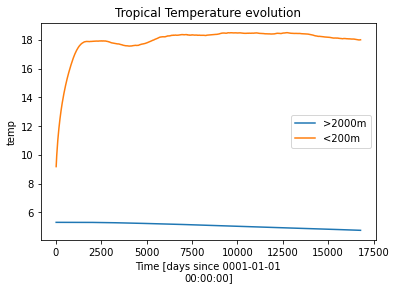

In [51]:
# Timeseries of deep tropical temp
darray = cc.querying.getvar(experiment, 'temp', session,ncfile='prog_ave.nc',decode_times=False)
deep_temp = darray.sel(zl=slice(2000,4000)).mean('zl').sel(yh=slice(-30,30)).mean('yh').sel(xh=slice(10,30)).mean('xh')
deep_temp.plot(label='>2000m')

shallow_temp = darray.sel(zl=slice(0,200)).mean('zl').sel(yh=slice(-30,30)).mean('yh').sel(xh=slice(10,30)).mean('xh')
shallow_temp.plot(label='<200m')
plt.legend()
plt.title('Tropical Temperature evolution')

# Plotting some maps

In [4]:
def plot_mercator(ax,X0,Y0):
    X,Y = np.meshgrid(X0,Y0)
    X_alt = (X - 20)*np.cos(Y*np.pi/180) + 20
    
    ax.set_frame_on(False)
    ax.plot(X_alt[:,0],Y[:,0],'k')
    ax.plot(X_alt[:,-1],Y[:,-1],'k')
    ax.plot([X_alt[-1,0], X_alt[-1,-1]],[69.8, 69.8],'k')
    ax.plot([X_alt[0,0], X_alt[0,-1]],[-70, -70],'k')
    ax.set_xlabel('Longitude')
    
    ax.set_ylim(ymin=-70,ymax=70)
    plt.setp(ax,'xticks',[10, 20, 30])
    return X_alt, Y

Text(0.5, 1.0, 'Speed Snapshot')

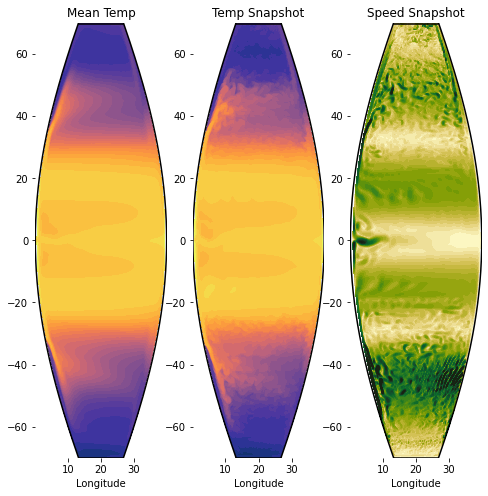

In [23]:
fig, ax = plt.subplots(1,3,figsize=(8,8))
vlev = np.linspace(-2,32,34)

#
darray = cc.querying.getvar(experiment, 'temp', session,ncfile='prog_ave.nc',start_time='0020-01-01')
temp_surf = darray.mean('Time').isel(zl=0)
X,Y = plot_mercator(ax[0],temp_surf.coords['xh'],temp_surf.coords['yh'])
p1=ax[0].contourf(X,Y,temp_surf,levels=vlev,extend='both',cmap=cm.cm.thermal)
ax[0].set_title('Mean Temp')

#
darray = cc.querying.getvar(experiment, 'temp', session,ncfile='prog.nc',start_time='0020-01-01')
temp_snap = darray.isel(Time=-1).isel(zl=0)
X,Y = plot_mercator(ax[1],temp_snap.coords['xh'],temp_surf.coords['yh'])
p1=ax[1].contourf(X,Y,temp_snap,levels=vlev,extend='both',cmap=cm.cm.thermal)
ax[1].set_title('Temp Snapshot')

#
slev = np.linspace(0,1,26)
darray = cc.querying.getvar(experiment, 'u', session,ncfile='prog.nc',start_time='0020-01-01')
u_snap = darray.isel(Time=-1).isel(zl=0)
darray = cc.querying.getvar(experiment, 'v', session,ncfile='prog.nc',start_time='0020-01-01')
v_snap = darray.isel(Time=-1).isel(zl=0)
speed = (u_snap.values[:,:-1]**2 + v_snap[:-1,:].values**2)**(0.5)
X,Y = plot_mercator(ax[2],temp_surf.coords['xh'],temp_surf.coords['yh'])
p1=ax[2].contourf(X,Y,speed,levels=slev,extend='both',cmap=cm.cm.speed)
ax[2].set_title('Speed Snapshot')



# A temperature profile
Note that I'm not averaging zero-thickness cells properly here.

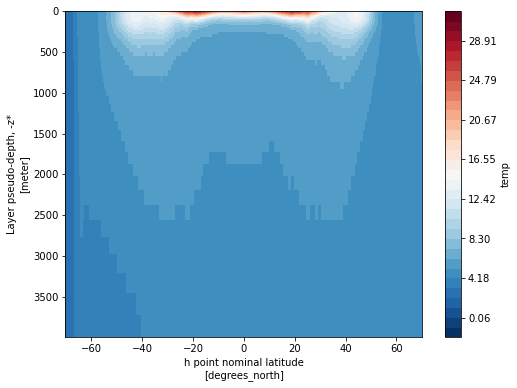

In [47]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
vlev = np.linspace(-2,32,34)

darray = cc.querying.getvar(experiment, 'temp', session,ncfile='prog_ave.nc',start_time='0030-01-01')
temp_slice = darray.mean('Time').sel(xh=slice(10,30)).mean('xh')
temp_slice.plot(levels=vlev,yincrease=False)

# Overturning Circulation
This diagnostic needs tuning!

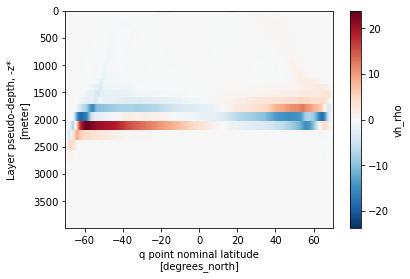

In [48]:
darray = cc.querying.getvar(experiment, 'vh_rho', session,ncfile='prog_ave.nc',start_time='0020-01-01')
moc = darray.sum('xh').mean('Time')/1e6
moc.plot(yincrease=False)

# Diffusivity

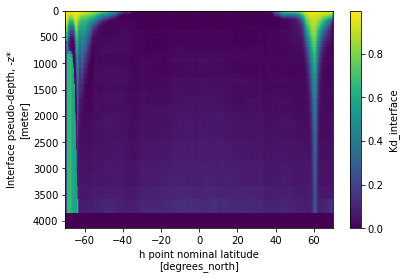

In [49]:
darray = cc.querying.getvar(experiment, 'Kd_interface', session,ncfile='turb.nc',start_time='0040-01-01')
Kd = darray.mean('xh').mean('Time')
Kd.plot(yincrease=False)